In [51]:
import numpy as np  
import pandas as pd 
import json
from datetime import date
from tqdm.auto import tqdm
tqdm.pandas()

from fhir.resources.bundle import Bundle
from fhir.resources.patient import Patient
from fhir.resources.condition import Condition
from fhir.resources.observation import Observation
from fhir.resources.medicationrequest import MedicationRequest
from fhir.resources.procedure import Procedure
from fhir.resources.encounter import Encounter
from fhir.resources.claim import Claim
from fhir.resources.immunization import Immunization

C:\Users\hanwe\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [52]:
# Define the directory where the files should be located
fhir_directory = 'C:/Users/hanwe/Documents/FHIR_1K_Synthea/Extracted_Data/fhir'

In [53]:
import os
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from datetime import datetime


In [54]:

# Define the FHIR directory
fhir_directory = 'C:/Users/hanwe/Documents/FHIR_1K_Synthea/Extracted_Data/fhir'

# Initialize a list to store extracted patient data
patient_data_list = []

# Function to calculate age from birthdate
def calculate_age(birth_date):
    try:
        birth_date = datetime.strptime(birth_date, "%Y-%m-%d")
        today = datetime.today()
        age = today.year - birth_date.year
        # Check if the birthday has occurred this year
        if today.month < birth_date.month or (today.month == birth_date.month and today.day < birth_date.day):
            age -= 1
        return age
    except Exception as e:
        print(f"Error calculating age for birthdate {birth_date}: {e}")
        return 'N/A'  # If the birth date is missing or malformed

# Iterate through all FHIR files in the specified directory
for filename in tqdm(os.listdir(fhir_directory), desc="Processing files"):
    if filename.endswith(".json"):  # Only process JSON files
        file_path = os.path.join(fhir_directory, filename)
        
        try:
            # Open and load the JSON data with the correct encoding
            with open(file_path, "r", encoding="utf-8") as file:
                data = json.load(file)
        except UnicodeDecodeError as e:
            # In case of a UnicodeDecodeError, try a different encoding
            print(f"Error reading file {filename}: {e}")
            try:
                with open(file_path, "r", encoding="latin1") as file:
                    data = json.load(file)
            except Exception as e2:
                print(f"Error loading {filename} with latin1 encoding: {e2}")
                continue  # Skip this file if it fails to load

        # Loop through the entries in the FHIR bundle and extract Patient data
        if 'entry' in data:  # Check if the 'entry' key exists
            for entry in data['entry']:
                if entry['resource']['resourceType'] == 'Patient':
                    # Extract the Patient resource
                    patient_resource = entry['resource']

                    try:
                        # Extract Patient Basic Info
                        patient_id = patient_resource.get('id', 'N/A')
                        patient_birth_date = patient_resource.get('birthDate', 'N/A')
                        
                        # Full official name with GIVEN NAME and FAMILY NAME
                        # Extract Patient Name (Official)
                        patient_name = ','.join([f"{''.join(name.get('given', ['N/A']))} {name.get('family','N/A')}" 
                                                 for name in patient_resource.get('name', [])
                        if name.get('use') == 'official'])
                        
                        # If no official name is found, set it to 'N/A'
                        if not patient_name:
                            patient_name = 'N/A'

                        # Calculate Age
                        age = 'N/A'  # Default if no birthDate is available
                        if patient_birth_date != 'N/A':
                            age = calculate_age(patient_birth_date)

                        # Gender and Address
                        patient_gender = patient_resource.get('gender', 'N/A')
                        addresses = patient_resource.get('address', [])
                        address = ', '.join([
                            f"{''.join(addr.get('line', ['N/A']))}, {addr.get('city', 'N/A')}, {addr.get('state', 'N/A')} {addr.get('postalCode', 'N/A')}" 
                            for addr in addresses])

                        # Marital Status
                        marital_status = patient_resource.get('maritalStatus', {}).get('text', 'N/A')

                        # Loop through 'communication' to find the first language
                        language_spoken = 'N/A'
                        for comm in patient_resource.get('communication', []):
                            if 'language' in comm and comm['language'].get('coding'):
                                language_spoken = comm['language']['coding'][0].get('display', 'N/A')
                                break

                        # Extract Race
                        race = 'N/A'
                        for extension in patient_resource.get('extension', []):
                            if extension.get('url') == "http://hl7.org/fhir/us/core/StructureDefinition/us-core-race":
                                for sub_extension in extension.get('extension', []):
                                    if sub_extension["url"] == "ombCategory":
                                        race = sub_extension["valueCoding"]["display"]
                                    elif sub_extension["url"] == "text":
                                        race = sub_extension["valueString"]

                        # Extract Ethnicity
                        ethnicity = 'none'
                        for extension in patient_resource.get('extension', []):
                            if extension.get('url') == "http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity":
                                for sub_extension in extension.get('extension', []):
                                    if sub_extension['url'] == 'ombCategory':
                                        ethnicity = sub_extension['valueCoding']['display']
                                    elif sub_extension["url"] == "text":
                                        ethnicity = sub_extension["valueString"]

                        # Extract SSN
                        ssn = 'none'
                        for identifier in patient_resource.get('identifier', []):
                            if 'us-ssn' in identifier['system']:
                                ssn = identifier['value']

                        # Append extracted data to the list
                        patient_data_list.append({
                            'Patient ID': patient_id,
                            'Name': patient_name,
                            'Birth Date': patient_birth_date,
                            'Age': age,
                            'Gender': patient_gender,
                            'Race': race,
                            'Ethnicity': ethnicity,
                            'Marital Status': marital_status,
                            'Language': language_spoken,
                            'Address': address,
                            'SSN': ssn
                        })

                    except Exception as e:
                        print(f"Error processing patient {patient_id}: {e}")
                        continue  # Skip this patient if there was an error

# Convert the list of patient data into a pandas DataFrame for easier manipulation and plotting
df = pd.DataFrame(patient_data_list)

# Save the entire dataset as CSV (entire extracted data)
output_csv_path = 'patients_extracted_data.csv'
df.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Patient data extraction completed and saved to {output_csv_path}.")


Processing files: 100%|████████████████████████████████████████████████████████████| 1180/1180 [00:55<00:00, 21.20it/s]

Patient data extraction completed and saved to patients_extracted_data.csv.


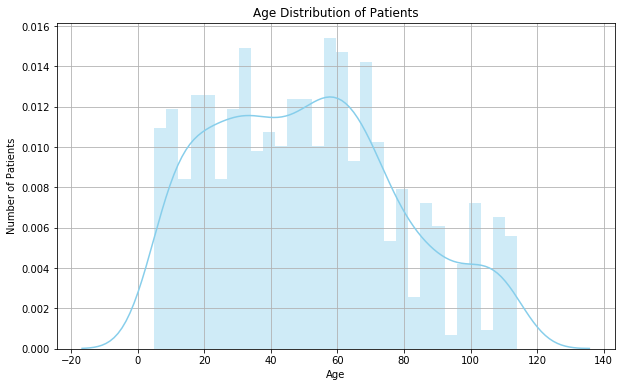

In [55]:
# Visualization: Age Distribution (Histogram using distplot)

df = pd.DataFrame(patient_data_list) 

plt.figure(figsize=(10, 6))
sns.distplot(df['Age'], kde=True, bins=30, color='skyblue')  # Replacing histplot with distplot
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.savefig('Age Distribution.png')
plt.show()

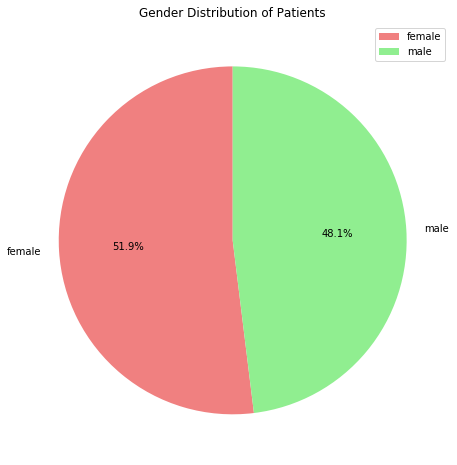

In [45]:
# Visualization: Gender Distribution (Pie Chart)
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(8, 8))
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90, legend=True)
plt.title('Gender Distribution of Patients')
plt.ylabel('')  # Remove y-axis label
plt.savefig('Gender Distribution.png')
plt.show()

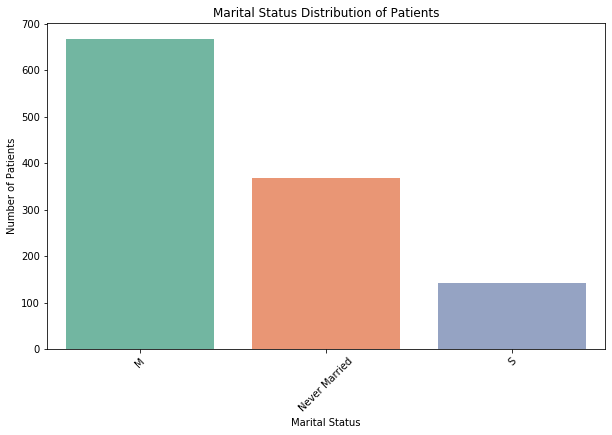

In [46]:
# Visualization: Marital Status Distribution (Bar Chart)
marital_status_counts = df['Marital Status'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=marital_status_counts.index, y=marital_status_counts.values, palette='Set2')
plt.title('Marital Status Distribution of Patients')
plt.xlabel('Marital Status')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.savefig('Marital Status Distribution.png')
plt.show()

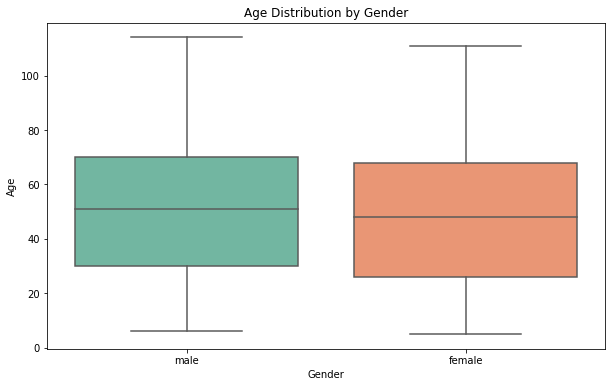

In [47]:
# Visualization : Age vs Gender (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age', data=df, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.savefig('Age vs Gender.png')
plt.show()

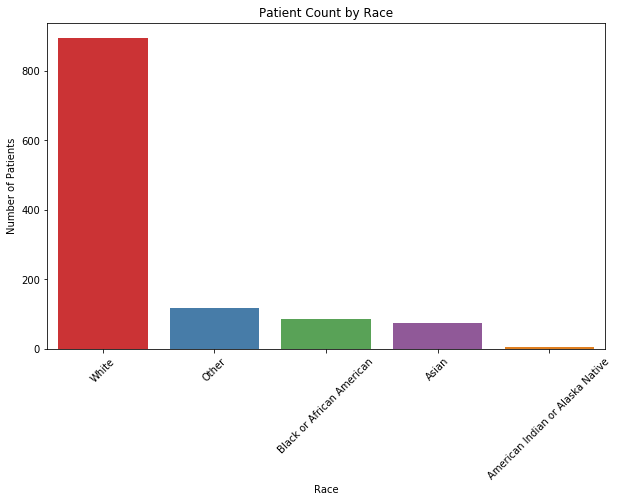

In [48]:
race_counts = df['Race'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values, palette='Set1')
plt.title('Patient Count by Race')
plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.savefig('Patient Count by Race.png')
plt.show()

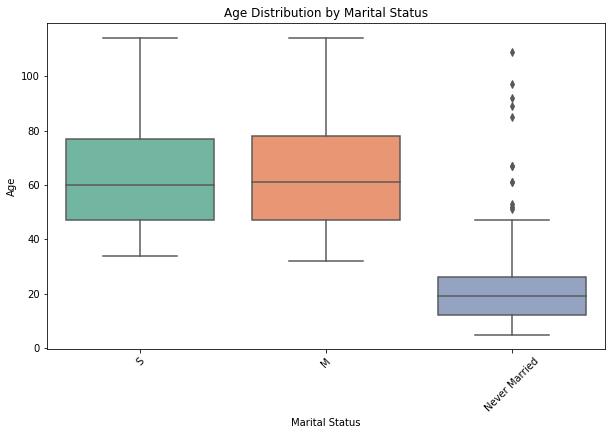

In [49]:
# Visualization : Age Distribution by Marital Status (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Marital Status', y='Age', data=df, palette='Set2')
plt.title('Age Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.savefig('Age Distribution by Marital Status.png')
plt.show()

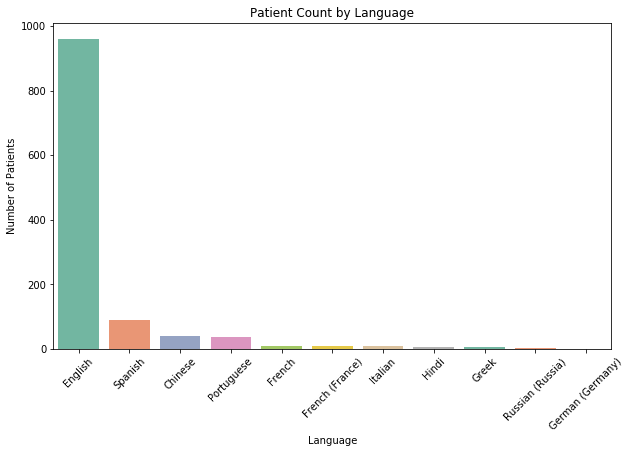

In [50]:
# Visualization: Patient Count by Language (Bar Chart)

language_counts = df['Language'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='Set2')
plt.title('Patient Count by Language')
plt.xlabel('Language')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.savefig('Patient Count by Language.png')
plt.show()